 ## Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import time
from tqdm import tqdm

2024-06-13 16:39:39.951538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 16:39:39.951684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 16:39:40.101448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
softvote=False
thres_perc=False
thres_perc_iter=False
thres_perc_multi=True
assert sum([softvote, thres_perc, thres_perc_iter, thres_perc_multi]) == 1, "Only one variable can be True at a time"
load_path='/kaggle/input/aewtf/tensorflow2/v15-ae32-16nodrtnosigm10kebt30kes35lre-4/1'
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tf.config.list_logical_devices('TPU'))
except ValueError:
    tpu = None

    
if tpu:
    strategy = tf.distribute.TPUStrategy(tpu)
elif len(tf.config.list_physical_devices('GPU'))>1:
    strategy = tf.distribute.MirroredStrategy()
    print(tf.config.list_physical_devices('GPU'))
else:
    # Default distribution strategy in TensorFlow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
print(strategy)
print(type(strategy))
strategy

REPLICAS:  1
<class 'tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy'>


 ## Read data

In [3]:
csvdata = pd.read_csv('/kaggle/input/awid3-csv-wlan-only/CSV/awid_full.csv', low_memory=False)

In [4]:
bool_cols = ["wlan_rsna_eapol.keydes.data_bool", "data.data_bool"]

for col in bool_cols:
    csvdata[col] = csvdata[col].astype(int)

In [5]:
csvdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15574909 entries, 0 to 15574908
Data columns (total 40 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   frame.len                                float64
 1   frame.number                             float64
 2   frame.time_delta_displayed               float64
 3   frame.time_epoch                         float64
 4   frame.time_relative                      float64
 5   wlan.duration                            float64
 6   wlan.fc.ds                               int64  
 7   wlan.fc.protected                        float64
 8   wlan.fc.type                             float64
 9   wlan.fc.retry                            float64
 10  wlan.fc.subtype                          float64
 11  wlan.fixed.reason_code                   float64
 12  wlan.fixed.timestamp                     float64
 13  wlan.seq                                 float64
 14  wlan_radio.data_

In [6]:
# for col in csvdata.columns:
#     if pd.api.types.is_numeric_dtype(csvdata[col]):
#         info = np.iinfo(csvdata[col].dtype) if 'int' in str(csvdata[col].dtype) else np.finfo(csvdata[col].dtype)
#         if csvdata[col].min() >= info.min and csvdata[col].max() <= info.max:
#             csvdata[col] = pd.to_numeric(csvdata[col], downcast='integer')
#             csvdata[col] = pd.to_numeric(csvdata[col], downcast='float')

In [7]:
# csvdata.info()

In [8]:
sc = StandardScaler()
sc.fit(csvdata.drop(columns=['Label']))

StandardScaler()

In [9]:
train_data, test_data = train_test_split(csvdata, test_size=0.2, stratify=csvdata['Label'], random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Label'], random_state=42)

In [10]:
label_mapping = {
    "Normal": 0,
    "Kr00k": 1,
    "Evil_Twin": 2,
    "Disas": 3,
    "Krack": 4,
    "Deauth": 5,
    "(Re)Assoc": 6,
    "RogueAP": 7
}

# Prepare data for each class
def prepare_class_data(train_data, label, scaler):
    class_data = train_data[train_data['Label'] == label].drop(columns=['Label'])
    return scaler.transform(class_data)

classes = list(label_mapping.keys())
class_data_dict = {label: prepare_class_data(train_data, label, sc) for label in classes}
# val_class_data_dict = {label: prepare_class_data(val_data, label, sc) for label in classes}

In [11]:
for label in classes:
    print(f'{label}: {class_data_dict[label].shape}')

Normal: (12085923, 39)
Kr00k: (153442, 39)
Evil_Twin: (83861, 39)
Disas: (60105, 39)
Krack: (39992, 39)
Deauth: (31154, 39)
(Re)Assoc: (4402, 39)
RogueAP: (1048, 39)


 ## Autoencoder network

In [12]:
def create_autoencoder(input_shape, strategy):
    with strategy.scope():
        model = models.Sequential([
            layers.Input(shape=(input_shape,)),
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(input_shape)
        ])
#         From dnn
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['accuracy'])
#         model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
        model.summary()
    return model

In [13]:
input_shape = csvdata.shape[1] - 1
print(strategy)

In [14]:
del csvdata
gc.collect()

0

## Loading

In [15]:
def load_autoencoders(classes, input_shape):
    autoencoders = {}
    for label in classes:
        model = create_autoencoder(input_shape, strategy)
        model.load_weights(os.path.join(load_path,f'autoencoder_{label}.h5'))
        autoencoders[label] = model
    return autoencoders

In [35]:
def load_thresholds(classes):
    thresholds = {}
    for label in classes:
        # Load thresholds from a file or set manually
        thresholds[label] = np.load(os.path.join('/kaggle/input/v4-v15model0max250valdata-5testdata',f'{label}_threshold.npy'))
        thresholds[label]=thresholds[label].item()
    return thresholds

In [38]:
autoencoders = load_autoencoders(classes, input_shape)
thresholds = load_thresholds(classes)
optimal_thresholds = load_thresholds(classes)

In [37]:
thresholds

{'Normal': 128.88113126786976,
 'Kr00k': 57.55756677370387,
 'Evil_Twin': 57.94048364690145,
 'Disas': 60.638981793138264,
 'Krack': 53.17877924767498,
 'Deauth': 56.81729043717894,
 '(Re)Assoc': 63.15697280973475,
 'RogueAP': 57.06696122399183}

## Calculate reconstruction error thresholds

In [ ]:
def plot_mse_histogram(mse, label, threshold):
    plt.figure(figsize=(10, 6))
    sns.histplot(mse, bins=50, kde=True)
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.title(f'Reconstruction Error for {label}')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [ ]:
percentiles = {
    "Normal": 95,
    "Kr00k": 50,
    "Evil_Twin": 65,
    "Disas": 50,
    "Krack": 70,
    "Deauth": 55,
    "(Re)Assoc": 45,
    "RogueAP": 50
}

In [ ]:
if thres_perc_multi:
    def cache_reconstruction_errors(data, autoencoders):
        errors = {}
        for label in classes:
            model = autoencoders[label]
            reconstructions = model.predict(data, batch_size=32768, verbose=2)
            mse = np.mean(np.power(data - reconstructions, 2), axis=1)
            errors[label] = mse
        return errors
    
    def evaluate_multiclass_performance(val_errors, thresholds, val_labels):
        predictions = np.zeros(val_errors[classes[0]].shape[0], dtype=int)
        scores = np.zeros((val_errors[classes[0]].shape[0], len(classes)))

        for i, label in enumerate(classes):
            scores[:, i] = val_errors[label]

        for i in range(len(val_errors[classes[0]])):
            class_scores = scores[i, :]
            min_score = np.min(class_scores)
            predicted_class = np.argmin(class_scores)
            if class_scores[predicted_class] > thresholds[classes[predicted_class]]:
                predictions[i] = len(classes)  # Assign to an additional class for high MSE (unknown class)
            else:
                predictions[i] = predicted_class

        return f1_score(val_labels, predictions, average='weighted')

    def optimize_thresholds(val_errors, val_labels):
        best_thresholds = {label: 0 for label in classes}
        best_f1 = 0

        for i, label in enumerate(classes):
            mse = val_errors[label]
            start_time= time.time()
#             for threshold in np.linspace(0, np.percentile(mse, 100), 100):
            for threshold in np.linspace(0, max(mse), 250):
                thresholds = best_thresholds.copy()
                thresholds[label] = threshold
                f1 = evaluate_multiclass_performance(val_errors, thresholds, val_labels)

                if f1 > best_f1:
                    best_f1 = f1
                    best_thresholds[label] = threshold
            print(f'Label {label} took {time.time()-start_time} seconds')
            print(f'Best F1 at label {label}: {best_f1} at threshold {best_thresholds[label]} (Index: {np.where(np.linspace(0, max(mse), 250) == best_thresholds[label])[0][0]})\n')
            np.save(f'{label}_threshold.npy', best_thresholds[label])
#             print(f'Best thresholds at {label}: {best_thresholds}')

        return best_thresholds, best_f1   

In [ ]:
if thres_perc_multi:
    # Prepare validation data and labels
    val_labels = val_data['Label'].map(label_mapping)
    val_data_scaled = sc.transform(val_data.drop(columns=['Label']))
    val_errors = cache_reconstruction_errors(val_data_scaled, autoencoders)
    # Find optimal thresholds
    optimal_thresholds, best_f1 = optimize_thresholds(val_errors, val_labels)
    print(f'Optimal thresholds: {optimal_thresholds}, Best F1-score: {best_f1}')

In [ ]:
if thres_perc:
    def calculate_threshold(data, model, percentile, label):
        reconstructions = model.predict(data, batch_size=32768, verbose=2)
        mse = np.mean(np.power(data - reconstructions, 2), axis=1)
        threshold = np.percentile(mse, percentile)  # Set threshold to 95th percentile
    #     np.save(f'{label}_reconstructions.npy', reconstructions)
        plot_mse_histogram(mse,label,threshold)
        return threshold

    thresholds = {label: calculate_threshold(class_data_dict[label], autoencoders[label], percentiles[label], label) for label in classes}

In [ ]:
if thres_perc_iter:
    def find_optimal_threshold(val_data, model, metric=f1_score):
        reconstructions = model.predict(val_data, batch_size=32768, verbose=2)
        mse = np.mean(np.power(val_data - reconstructions, 2), axis=1)

        best_threshold = 0
        best_score = 0
        best_q = 0
        q=0
        percs=np.arange(1, 100, 0.5)
#         print(max(mse))
        for threshold in np.percentile(mse,percs):
#         for threshold in np.linspace(0, max(mse), 100):
            preds = mse < threshold
            score = metric(np.ones_like(preds), preds)

            if score > best_score:
                best_score = score
                best_threshold = threshold
                best_q=q
            q+=1
        print(f'Best q: {percs[best_q]}')      
        plot_mse_histogram(mse,label,best_threshold)
        return best_threshold, best_score

    thresholds = {}
    for label in classes:
        metric=f1_score
        thresholds[label], best_score = find_optimal_threshold(class_data_dict[label], autoencoders[label], metric)
        print(f'Optimal threshold for {label}: {thresholds[label]}, Best {metric.__name__}: {best_score}')

In [ ]:
if thres_perc or thres_perc_iter:
    print(thresholds)
    for label in classes:
        np.save(f'{label}_threshold.npy', thresholds[label])

 ## Calculate reconstruction error probabilities

In [ ]:
if softvote:
    def calculate_reconstruction_error(model, data):
        reconstructions = model.predict(data, batch_size=32768, verbose=2)
        mse = np.mean(np.power(data - reconstructions, 2), axis=1)
        return mse, reconstructions

    val_reconstruction_errors = {label: calculate_reconstruction_error(autoencoders[label], class_data_dict[label])[0] for label in classes}

    val_error_distributions = {label: norm.fit(val_reconstruction_errors[label]) for label in val_reconstruction_errors}

In [ ]:
if softvote:
    del val_reconstruction_errors
    gc.collect()

 ## Binary and Multi-class classification

In [19]:
labels = test_data['Label'].map(label_mapping)
data = test_data.drop(columns=['Label'])
data = sc.transform(data)

In [39]:
if thres_perc_multi:
    def multi_classification_predict(data, thresholds, autoencoders):
        predictions = np.zeros(data.shape[0], dtype=int)
        scores = np.zeros((data.shape[0], len(classes)))

        for i, label in enumerate(classes):
            model = autoencoders[label]
            reconstructions = model.predict(data, batch_size=32768, verbose=2)
            mse = np.mean(np.power(data - reconstructions, 2), axis=1)
            scores[:, i] = mse

        for i in range(data.shape[0]):
            class_scores = scores[i, :]
            min_score = np.min(class_scores)
            predicted_class = np.argmin(class_scores)
            if class_scores[predicted_class] > thresholds[classes[predicted_class]]:
                predictions[i] = len(classes)  # Assign to an additional class for high MSE (unknown class)
            else:
                predictions[i] = predicted_class

        return predictions
    predictions = multi_classification_predict(data, optimal_thresholds, autoencoders)

48/48 - 1s - 24ms/step
48/48 - 1s - 13ms/step
48/48 - 1s - 12ms/step
48/48 - 1s - 13ms/step
48/48 - 1s - 12ms/step
48/48 - 1s - 13ms/step
48/48 - 1s - 13ms/step
48/48 - 1s - 12ms/step


In [ ]:
if thres_perc or thres_perc_iter:
    def binary_classification(data, model, threshold, label):
        reconstructions = model.predict(data, batch_size=32768, verbose=2)
        mse = np.mean(np.power(data - reconstructions, 2), axis=1)
    #     np.save(f'{label}_classification_reconstructions.npy', reconstructions)
        plot_mse_histogram(mse,label,threshold)
        return mse < threshold

    def multi_classification_predict(data):
        predictions = np.zeros(data.shape[0])
        scores = np.zeros((data.shape[0], len(classes)))

        for i, label in enumerate(classes):
            binary_preds = binary_classification(data, autoencoders[label], thresholds[label], label)
            scores[:, i] = binary_preds

        predictions = np.argmax(scores, axis=1)
        return predictions

    predictions = multi_classification_predict(data)

In [ ]:
if softvote:
    def calculate_probabilities(model, data, mu, sigma):
        reconstructions = model.predict(data, batch_size=32768, verbose=2)
        mse = np.mean(np.power(data - reconstructions, 2), axis=1)
        probabilities = norm.pdf(mse, mu, sigma)
        return probabilities

    def multi_classification_probabilities(data):
        probabilities = np.zeros((data.shape[0], len(autoencoders)))
        for i, label in enumerate(autoencoders):
            mu, sigma = val_error_distributions[label]
            probabilities[:, i] = calculate_probabilities(autoencoders[label], data, mu, sigma)
        return probabilities

    def soft_voting_predict(probabilities):
        return np.argmax(probabilities, axis=1)

In [ ]:
if softvote:
    test_probabilities = multi_classification_probabilities(data)
    predictions = soft_voting_predict(test_probabilities)

 ## Evaluation

In [41]:
print(np.unique(predictions, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([1510029,   19209,   10570,    8010,    4895,    3916,     728,
           131,       3]))


In [55]:
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1510741,   19180,   10483,    7513,    4999,    3894,     550,
           131]))


In [42]:
# Exclude unknown class from metrics calculation
valid_indices = predictions != len(classes)

In [57]:
filtered_predictions = predictions[valid_indices]
filtered_test_labels = labels[valid_indices]

In [47]:
print(np.unique(filtered_predictions, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1510029,   19209,   10570,    8010,    4895,    3916,     728,
           131]))


In [58]:
print(np.unique(filtered_test_labels, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1510738,   19180,   10483,    7513,    4999,    3894,     550,
           131]))


In [ ]:
# predictions_labels = [classes[pred] for pred in predictions]

In [ ]:
# del data
# del labels
# del predictions
del test_data
gc.collect()

In [59]:
print("Classification Report:")
print(classification_report(filtered_test_labels, filtered_predictions))
# print(classification_report(test_data['Label'], predictions_labels, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1510738
           1       1.00      1.00      1.00     19180
           2       0.99      1.00      0.99     10483
           3       0.94      1.00      0.97      7513
           4       0.84      0.83      0.84      4999
           5       0.99      1.00      0.99      3894
           6       0.75      1.00      0.86       550
           7       1.00      1.00      1.00       131

    accuracy                           1.00   1557488
   macro avg       0.94      0.98      0.96   1557488
weighted avg       1.00      1.00      1.00   1557488



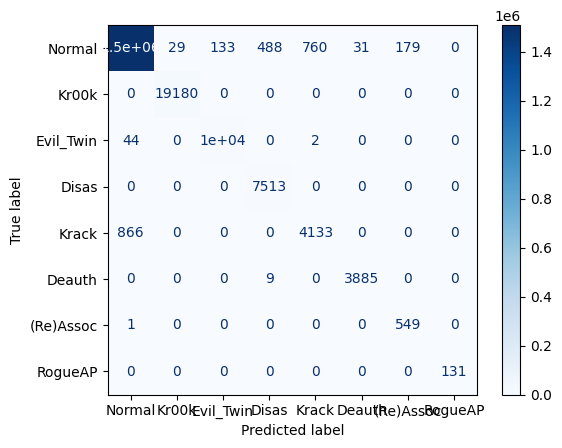

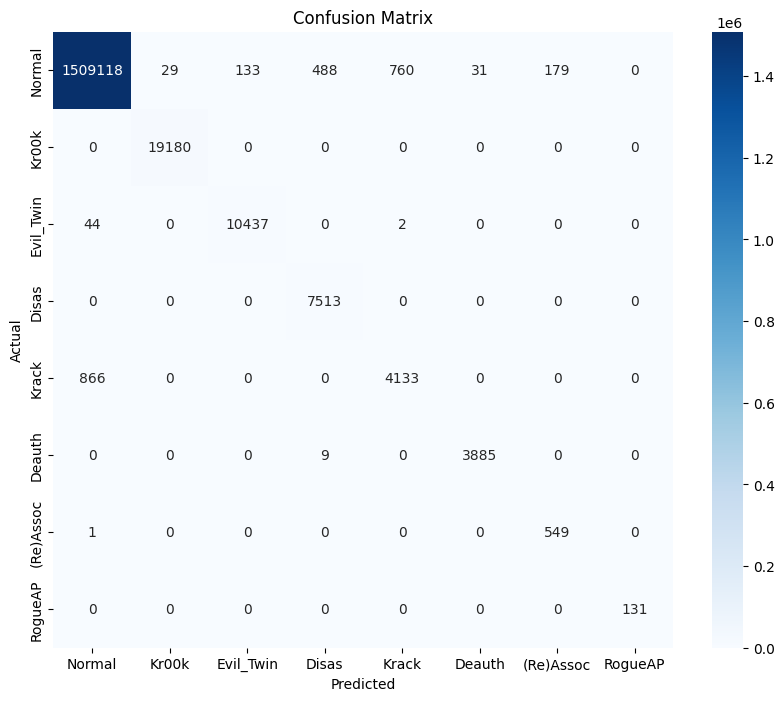

In [60]:

# Compute and print confusion matrix
cm = confusion_matrix(filtered_test_labels, filtered_predictions, labels=list(range(len(classes))))
# cm = confusion_matrix(test_data['Label'], predictions_labels, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
